## Ejemplo clasificatorio sobre enfermos de cancer

Importo los datos de kaggle "Breast Cancer Wisconsin";<p> https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/data <p>
Información sobre los datos en : <p>
https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names<p> <p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, metrics

Tomo como $y=1$ la diagnosis de un tumor maligno, $y=0$ la diagnosis de tumor benigno.

In [2]:
data = pd.read_csv('data/cancer.csv').ix[:, 1:32]
data['diagnosis']=data['diagnosis'].map({'M':1,'B':0})

Primero divido la muestra en entrenamiento, validación y test con proporcion (60/20/20) <p>

In [3]:
train, validate, test = np.split(data.sample(frac=1, random_state=42),
                                 [int(.6*len(data)), int(.8*len(data))])
X_train = np.array(train.ix[:,2:32])
y_train = np.array(train['diagnosis'])
X_validate = np.array(validate.ix[:,2:32])
y_validate = np.array(validate['diagnosis'])
X_test = np.array(test.ix[:,2:32])
y_test = np.array(test['diagnosis'])

Calculo distintos modelos variando el parámetro de regularización C. <p>
Calculo para la Accuracy para mis tres particiones en los datos.<p>
Calculo la sensibilidad, precisión y especificidad de cada modelo con el test set.

In [4]:
list_C = np.arange(100 , 1000, 1)
score_train = np.zeros(len(list_C)); score_val = np.zeros(len(list_C))
score_test = np.zeros(len(list_C)) ; recall_test = np.zeros(len(list_C))
precision_test= np.zeros(len(list_C)); count = 0

for C in list_C:
    reg = linear_model.LogisticRegression(C=C)
    reg.fit(X_train, y_train)
    score_train[count]= metrics.accuracy_score(
        y_train, reg.predict(X_train))
    score_val[count] = metrics.accuracy_score(
        y_validate, reg.predict(X_validate))
    score_test[count] = metrics.accuracy_score(
        y_test, reg.predict(X_test))
    recall_test[count] = metrics.recall_score(
        y_test, reg.predict(X_test))
    precision_test[count] = metrics.precision_score(
        y_test, reg.predict(X_test))
    count = count + 1 

Creo un data frame para cada modelo de regresión logística utilizado. <p>
Cada modelo tiene distinto parámetro C, muestro la accuracy en cada data set.

In [5]:
matrix = np.matrix(np.c_[list_C, score_train, score_val, 
                         score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Validation Accuracy', 
              'Test Accuracy', 'Test Recall', 'Test Precision'])
models.ix[:, :4].head(n=5)

,C,Train Accuracy,Validation Accuracy,Test Accuracy
0,100.0,0.973607,0.964912,0.929825
1,101.0,0.976540,0.973684,0.921053
2,102.0,0.976540,0.964912,0.929825
3,103.0,0.982405,0.973684,0.929825
4,104.0,0.973607,0.964912,0.929825


Elijo el mejor modelo en función de la Accuracy en el validate test. Observo el resto de métricas.

In [6]:
best_index = models['Validation Accuracy'].idxmax()
models.ix[best_index, :]

C                      284.000000
Train Accuracy           0.985337
Validation Accuracy      0.982456
Test Accuracy            0.929825
Test Recall              0.893617
Test Precision           0.933333
Name: 184, dtype: float64

El modelo lo hemos elegido tomando como parámetro el validate set. <p>
La manera correcta de estimar la capacidad de generalización es evaluarla sobre el test set. <p>
Si lo hicieramos sobre el validate test, sobreestimariamos su capacidad al haberlo tomado como parámetro al elegir el modelo.

In [7]:
reg = linear_model.LogisticRegression(C=list_C[best_index])
reg.fit(X_train, y_train)

LogisticRegression(C=284, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Matriz de confusión evaluada en el **train set**

In [8]:
m_confusion_train = metrics.confusion_matrix(y_train,
                         reg.predict(X_train))
pd.DataFrame(data = m_confusion_train, 
            columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,216,2
Actual 1,3,120


Matriz de confusión evaluada en el **validation set**

In [9]:
m_confusion_validate = metrics.confusion_matrix(y_validate,
                         reg.predict(X_validate))
pd.DataFrame(data = m_confusion_validate, 
            columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,71,1
Actual 1,1,41


Matriz de confusión evaluada en el **test set**

In [10]:
m_confusion_test = metrics.confusion_matrix(y_test,
                         reg.predict(X_test))
pd.DataFrame(data = m_confusion_test, 
             columns = ['Predicted 0', 'Predicted 1'],
             index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,64,3
Actual 1,5,42


#### Observo sobre mi modelo que el error de generalización está sobre estimado si lo evaluo sobre el conjunto de validación
#### Esto es debido a que la elección del parámetro de regularización está sujeta a él.
#### Mi precisión al generalizar es aproximadamente un 93%.

Calculo la curva ROC haciendo blablabla

In [11]:
prob_1 = reg.predict_proba(X_validate)[:, 1]
fpr, tpr, thresholds = roc_curve(y_validate,prob_1, 
                                 pos_label = 1)
roc_auc = auc(fpr, tpr)

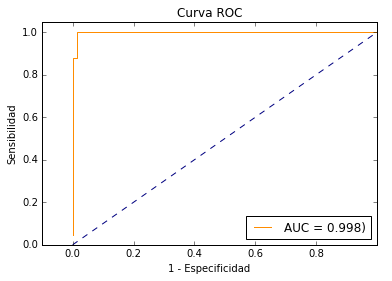

In [12]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()